In [1]:
# pyqubo stuff
from pyqubo import Array, Constraint


import math
import matplotlib.pyplot as plt
import numpy as np
import random
import re

## Constants

In [185]:
SQUARE_SIZE = 2
BITS = SQUARE_SIZE * SQUARE_SIZE

In [186]:
# get the vector index given the i, j, k magic square matrix identifiers
def get_index(i, j, k):
    
    # we need to know the length of the magic square matrix horizontally
    row_length = BITS * SQUARE_SIZE
    
    return int((i*row_length) + (j*BITS) + k)

## Magic Square Implementation

$$\sum_{i1\neq i2}^n\left[\sum_{j=1}^{n}\sum_{k=1}^{s}{x_{i2,j,k}} - \sum_{j=1}^{n}\sum_{k=1}^{s}{x_{i1,j,k}}\right]^2$$

In [187]:
def penalty_sum_row(H, variables, penalty=1):
    for row1 in range(SQUARE_SIZE):
        for row2 in range(SQUARE_SIZE):
            if row1 == row2:
                continue
            
            H_tmp = 0
            
            for j in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp += Constraint(variables[get_index(row2, j, k)], label=f"row2_{row2}_{j}_{k}")

            for j in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp -= Constraint(variables[get_index(row1, j, k)], label=f"row1_{row1}_{j}_{k}")

            H_tmp **= 2
            H += H_tmp

    H *= penalty

    return H
            

$$\sum_{j1\neq j2}^n\left[\sum_{i=1}^{n}\sum_{k=1}^{s}{x_{i,j2,k}} - \sum_{i=1}^{n}\sum_{k=1}^{s}{x_{i,j1,k}}\right]^2$$

In [188]:
def penalty_sum_col(H, variables, penalty=1):
    for col1 in range(SQUARE_SIZE):
        for col2 in range(SQUARE_SIZE):
            if col1 == col2:
                continue
            
            H_tmp = 0
            
            for i in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp += Constraint(variables[get_index(i, col2, k)], label=f"col1_{i}_{col2}_{k}")

            for i in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp -= Constraint(variables[get_index(i, col1, k)], label=f"col2_{i}_{col1}_{k}")

            H_tmp **= 2
            H += H_tmp

    H *= penalty

    return H
            

$$\sum_{i=1}^{n}\sum_{j=1}^{n}\left[\sum_{k=1}^{s-1}{x_{i,j,k+1} - x_{i,j,k+1}x_{i,j,k}}\right]$$

In [189]:
def penalty_domain_wall(H, variables, penalty=1):
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
            for k in range(BITS-1):
                H += penalty * Constraint(variables[get_index(i,j,k+1)] - (variables[get_index(i,j,k+1)] * variables[get_index(i,j,k)]), label=f"domain_wall_{i}_{j}_{k}")
    return H   

$$\sum_{i=1}^{n}\sum_{j=1}^{n}\left[\prod_{k=1}^{s}1 - (x_{i,j,k} \oplus 0)\right]$$

In [190]:
def penalty_empty(H, variables, penalty=1):

    def xor(var1, var2):
        return (var1 + var2) - (2 * var1 * var2)

    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
                H += Constraint(penalty * np.prod([1 - xor(var, 0) for var in list(variables)[get_index(i,j,0):get_index(i,j,BITS)]]), label=f"empty_{i}_{j}")

    return H
                

$$$$

In [191]:
def penalty_unique(H, variables, penalty=1):
    for k in range(BITS):
        H += Constraint(penalty * (sum(variables[get_index(i,j,k)] for i in range(SQUARE_SIZE) for j in range(SQUARE_SIZE)) * (1/(BITS-k)) - 1) ** 2, label=f"unique_{k}")

    return H


## Construct QUBO

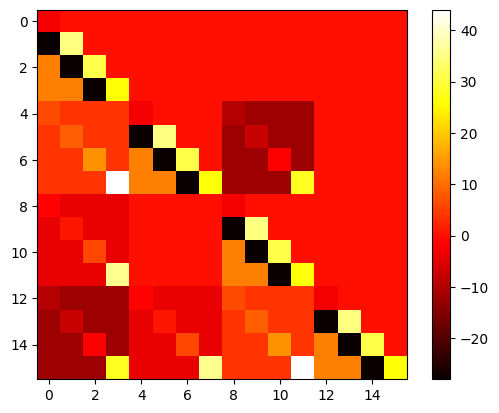

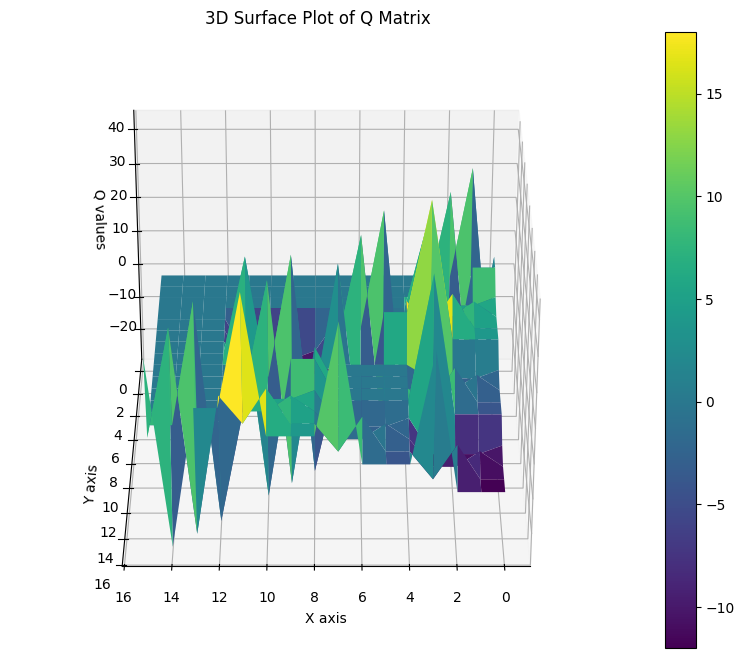

In [207]:
def show_2d(H):
    model = H.compile()
    qubo, offset = model.to_qubo()

    Q = np.zeros((SQUARE_SIZE * SQUARE_SIZE * BITS, SQUARE_SIZE * SQUARE_SIZE * BITS))

    for key, value in qubo.items():
        i = int(re.search(r'\[(\d+)\]', key[0]).group(1))
        j = int(re.search(r'\[(\d+)\]', key[1]).group(1))

        Q[i][j] = value



    plt.imshow(Q, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()

def show_3d(H):

    model = H.compile()
    qubo, offset = model.to_qubo()

    Q = np.zeros((SQUARE_SIZE * SQUARE_SIZE * BITS, SQUARE_SIZE * SQUARE_SIZE * BITS))

    for key, value in qubo.items():
        i = int(re.search(r'\[(\d+)\]', key[0]).group(1))
        j = int(re.search(r'\[(\d+)\]', key[1]).group(1))

        Q[i][j] = value
    
    # Create a meshgrid for the indices of the Q matrix
    x = np.arange(Q.shape[0])
    y = np.arange(Q.shape[1])
    x, y = np.meshgrid(x, y)

    # Create a figure and a 3D axis
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(x, y, Q, cmap='viridis')

    # Add a color bar which maps values to colors
    fig.colorbar(surf)
        
    # Set labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Q values')

    # Set title
    ax.set_title('3D Surface Plot of Q Matrix')

    ax.view_init(elev=30, azim=90)  # Adjust 'elev' as needed for better visibility

    plt.show()

array = Array.create('x', SQUARE_SIZE * SQUARE_SIZE * BITS, 'BINARY')

# apply constraints
H = 0
H += penalty_domain_wall(H, array, 5)
# H += penalty_empty(H, array, 1)
H += penalty_unique(H, array, 5)

H += penalty_sum_row(H, array, 1)
H += penalty_sum_col(H, array, 1)

show_2d(H)
show_3d(H)




## Simulated Annealing

In [208]:
import neal

# compile and convert to binary quadratic model
model = H.compile()
bqm = model.to_bqm()

# simulate
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=5000)
decoded_samples = model.decode_sampleset(sampleset)

# decode
solutions = []

for solution in decoded_samples:
    
    # get the sample and energy
    sample = solution.sample
    energy = solution.energy

    # split the sample values into bit sized chunks
    # sample = np.array([list(sample.values())[i:i+BITS] for i in range(0, len(sample), BITS)]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))
    sample = np.array([sample[f"x[{i}]"] for i in range(SQUARE_SIZE * SQUARE_SIZE * BITS)]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))  

    solutions.append({"sample": sample, "energy": energy})

## Real Annealing

## Analysis 

In [209]:
def to_decimal(item):
    if [1] * item.count(1) + [0] * item.count(0) == item:
        return sum(item)
    return -1


def get_grid(sample):
    grid = np.zeros((SQUARE_SIZE, SQUARE_SIZE))
    
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):

            # get the item
            item = list(sample[i][j])
            
            grid[i][j] = to_decimal(item)
            
    return np.array(grid)

def check_unary(sample):

    count = 0
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
            item = list(map(int, sample[i][j]))
            
            if [1] * item.count(1) + [0] * item.count(0) != item:
                count += 1

    if count == 0:
        return True
    
    return count


def check_unique(sample):
    grid = get_grid(sample)

    if len(set(grid.flatten())) == SQUARE_SIZE * SQUARE_SIZE:
        return True
    return False
    


def check_sum_col(sample):

    # get grid and sum cols
    grid = get_grid(sample)
    sums = [int(sum(grid[:,i])) for i in range(SQUARE_SIZE)]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False

def check_sum_row(sample):
    
    # get grid and sum rows
    grid = get_grid(sample)
    sums = [int(sum(grid[i,:])) for i in range(SQUARE_SIZE)]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False


unary_incorrect = {}

unary = 0
unique = 0
sumcol = 0
sumrow = 0

for solution in solutions:
    
    if check_unary(solution["sample"]) is True:
        unary += 1
    else:
        if check_unary(solution["sample"]) not in unary_incorrect:
            unary_incorrect.setdefault(check_unary(solution["sample"]), 1)
        else:
            unary_incorrect[check_unary(solution["sample"])] += 1
        continue
    
    if check_unique(solution["sample"]):
        unique += 1

    if check_sum_col(solution["sample"]):
        sumcol += 1

    if check_sum_row(solution["sample"]):
        sumrow += 1

print(f"Unary Correct: {unary}/{len(solutions)}")
print(f"Unique Correct: {unique}/{len(solutions)}")
print(f"Sum Column Correct: {sumcol}/{len(solutions)}")
print(f"Sum Row Correct: {sumrow}/{len(solutions)}")
print(f"OHE Incorrect: {unary_incorrect}")


Unary Correct: 5000/5000
Unique Correct: 4970/5000
Sum Column Correct: 0/5000
Sum Row Correct: 4970/5000
OHE Incorrect: {}


## Show Example

In [206]:
# condense into count
def condense_results(solutions):
    
    condensed = {}
    
    for solution in solutions:
        sample = solution["sample"]
        energy = solution["energy"]

        # extract the values
        key = str(sample.flatten())
        
        if key not in condensed:
            condensed[key] = {"count": 0, "energy": energy}
        
        condensed[key]["count"] += 1
    
    return condensed

condensed = condense_results(solutions)

for key, value in condensed.items():
    print(np.array(key.split()).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))) 
    print(get_grid(np.array([int(i) for i in key[1:-1].split(" ")]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))))
    print(value)
    print("\n\n")

[[['[1' '1' '1' '0']
  ['1' '1' '0' '0']]

 [['1' '1' '0' '0']
  ['1' '1' '1' '0]']]]
[[3. 2.]
 [2. 3.]]
{'count': 561, 'energy': 4.444444444444443}



[[['[1' '1' '1' '1']
  ['1' '1' '0' '0']]

 [['1' '1' '0' '0']
  ['1' '1' '1' '1]']]]
[[4. 2.]
 [2. 4.]]
{'count': 480, 'energy': 4.444444444444443}



[[['[1' '1' '0' '0']
  ['1' '1' '1' '0']]

 [['1' '1' '1' '0']
  ['1' '1' '0' '0]']]]
[[2. 3.]
 [3. 2.]]
{'count': 523, 'energy': 4.444444444444457}



[[['[1' '1' '0' '0']
  ['1' '1' '1' '1']]

 [['1' '1' '1' '1']
  ['1' '1' '0' '0]']]]
[[2. 4.]
 [4. 2.]]
{'count': 518, 'energy': 4.444444444444457}



[[['[1' '1' '1' '0']
  ['1' '0' '0' '0']]

 [['1' '0' '0' '0']
  ['1' '1' '1' '0]']]]
[[3. 1.]
 [1. 3.]]
{'count': 583, 'energy': 4.444444444444443}



[[['[1' '1' '1' '1']
  ['1' '0' '0' '0']]

 [['1' '0' '0' '0']
  ['1' '1' '1' '1]']]]
[[4. 1.]
 [1. 4.]]
{'count': 554, 'energy': 4.444444444444443}



[[['[1' '0' '0' '0']
  ['1' '1' '1' '0']]

 [['1' '1' '1' '0']
  ['1' '0' '0' '0]']]]
[[